In [3]:
import random
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
import timeit

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset  
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle
import math
import os
import time
from datetime import datetime, timedelta
import pandas as pd

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import random
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
import timeit

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset  
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle
import math
import os
import time
from datetime import datetime, timedelta
import pandas as pd

In [6]:
# arguments
args = {
    "batch_size" : 64,
    "num_clients": 12,# test 9 clients
    "num_malicious": 3, # test 1,3,5,8
    "frac": 1,
    "epoch_local": 3, #5
    "batch_size_local": 32,
    "epochs": 10,
    "dataset": "CIFAR10",
    "model": "CNN",
    "model_lr": 0.05,
    "iid": "iid",
    "test_mode": "unlearn_fake",
    "output": "",
    
    # Unlearning params
    "unlearn_client_list": [0, 1, 2],
    "t": 2, # calibration_interval,
    "r": 0.5 # local_calibration_epoch_ratio r = Ecali/Eloc
}

In [7]:
# turn on gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
# Client
class Client:
    num_clients = 0
    
    def __init__(self):
        self.id = Client.num_clients
        self.__model = None
        self.model_record = []
        self.device = device
        self.is_unlearned = False
        self.optimizer = None
        self.criterion = None
        self.history = []
        self.is_malicious = False

        Client.num_clients += 1
    
        
    def setup(self, args, dataset, model):
        self.local_epoch = args["epoch_local"]
        self.batch_size = args["batch_size_local"]
        self.dataset = dataset
        self.test_loader, self.val_loader, self.train_loader = self.split_test_val_train(self.dataset, self.batch_size)
        self.model = model
        
        if self.id < args["num_malicious"]:
            self.is_malicious = True
            
        self.setup_unlearn(args)
        
    def setup_unlearn(self, args):
        self.interval = args["t"]
        self.__cali_ratio = args["r"]
        self.unlearned_w = None
        
        
    def split_test_val_train(self, dataset, batch_size):
        test_split_mul = 0.1
        val_split_mul = 0.2

        dataset_size = len(dataset)
        
        indices = list(range(dataset_size))
        random.shuffle(indices)
        
        test_split = int(test_split_mul * dataset_size)
        val_split = int(val_split_mul * dataset_size)

        test_indices = indices[:test_split]
        val_indices = indices[test_split: test_split+val_split]
        train_indices = indices[test_split+val_split:]
        
        test_sampler = SubsetRandomSampler(test_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_sampler = SubsetRandomSampler(train_indices)

        test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = False,
                                           sampler=test_sampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = False,
                                           sampler=val_sampler)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = False,
                                           sampler=train_sampler)
        
        return test_loader, val_loader, train_loader
    
    
    @property
    def model(self):
        return self.__model
    
    
    @model.setter
    def model(self, model):
        self.__model = model
        
    @property
    def cali_ratio(self):
        return self.__cali_ratio
    
    
    @cali_ratio.setter
    def cali_ratio(self, cali_ratio):
        self.__cali_ratio = cali_ratio

    
    def get_weight(self):
        return self.model.state_dict()


    def set_weight(self, weight):
        self.model.load_state_dict(weight)

        
    def local_update(self):
        self.model.train()
        self.model.to(self.device)


        temp_history = {
            "train_loss": [], 
            "validation_loss": [], 
            "test_loss" : 0,
            "train_acc": [],
        
            "validation_acc": [],
            "test_acc" : 0
        }
        
        self.optimizer = optim.SGD(self.model.parameters(), lr= args["model_lr"])
        self.criterion = torch.nn.CrossEntropyLoss()
        
        for epoch in range(self.local_epoch):
            batch_loss = []
            # train an epoch
            for batch_idx, (images, labels) in enumerate(self.train_loader):
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # save batch loss
                batch_loss.append(loss.item()) 
            
            # save epoch loss
            temp_history["train_loss"].append(sum(batch_loss) / len(batch_loss))

            # validation
            with torch.no_grad():
                # imgages, labels = iter(self.val_loader).next()
                batch_val_acc = []
                batch_val_loss = []

                for images, labels in self.val_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    
                    pred = outputs.argmax(dim=1)
    
                    # save batch val loss
                    batch_val_loss.append(loss.item()) 

                    # save batch val acc
                    batch_val_acc.append(((pred == labels).sum().item()) / len(labels))
                
                # save epoch val loss  
                temp_history["validation_loss"].append(sum(batch_val_loss) / len(batch_val_loss))

                # save epoch val acc
                temp_history["validation_acc"].append(sum(batch_val_acc) / len(batch_val_acc))

            print(f"Train Epoch {epoch}: \tLoss: {(sum(batch_loss) / len(batch_loss)):.3f}")
            args["output"] += f"Train Epoch {epoch}: \tLoss: {(sum(batch_loss) / len(batch_loss)):.3f}\n"
            print(f"Validate Epoch {epoch}: \tLoss: {(sum(batch_val_loss) / len(batch_val_loss)):.3f}, \tAcc: {(sum(batch_val_acc) / len(batch_val_acc)):.3f}")
            args["output"] += f"Validate Epoch {epoch}: \tLoss: {(sum(batch_val_loss) / len(batch_val_loss)):.3f}, \tAcc: {(sum(batch_val_acc) / len(batch_val_acc)):.3f}\n"
        # test
        # print("-------------------- test client after train------------------")
        test_loss, test_acc = self.test(self.model)
        temp_history["test_loss"] = test_loss
        temp_history["test_acc"] = test_acc

        self.history.append(temp_history)
        self.model_record.append(self.model.state_dict())

        print(f"Test: \tLoss: {test_loss:.3f}, \tAcc: {test_acc:.3f}")
        args["output"] += f"Test: \tLoss: {test_loss:.3f}, \tAcc: {test_acc:.3f}\n"

        return self.model.state_dict(), test_loss, test_acc
    
    
    def test(self, model):
        test_loss = 0
        test_acc = 0

        model.eval()
        model.to(device)
        
        loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                
                loss += self.criterion(outputs, labels).item()
                pred = outputs.argmax(dim=1)
                correct += ((pred == labels).sum().item())/len(labels)
            

            test_loss = loss/len(self.test_loader)
            test_acc = correct/len(self.test_loader)

        return test_loss, test_acc
    
    
    def cali_train(self):
        self.model.train()
        self.model.to(self.device)


        temp_history = {
            "train_loss": [], 
            "validation_loss": [], 
            "test_loss" : 0,
            "train_acc": [],
        
            "validation_acc": [],
            "test_acc" : 0
        }
        
        self.optimizer = optim.SGD(self.model.parameters(), args["model_lr"])
        self.criterion = torch.nn.CrossEntropyLoss()
        
        local_cali_round = int(math.ceil(self.local_epoch*self.cali_ratio))

        for epoch in range(local_cali_round):
            batch_loss = []
            # train an epoch
            for batch_idx, (images, labels) in enumerate(self.train_loader):
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # save batch loss
                batch_loss.append(loss.item()) 
            
            # save epoch loss
            temp_history["train_loss"].append(sum(batch_loss) / len(batch_loss))

            # validation
            with torch.no_grad():
                batch_val_acc = []
                batch_val_loss = []

                for images, labels in self.val_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    
                    pred = outputs.argmax(dim=1)
    
                    # save batch val loss
                    batch_val_loss.append(loss.item()) 

                    # save batch val acc
                    batch_val_acc.append(((pred == labels).sum().item()) / len(labels))
                
                # save epoch val loss  
                temp_history["validation_loss"].append(sum(batch_val_loss) / len(batch_val_loss))

                # save epoch val acc
                temp_history["validation_acc"].append(sum(batch_val_acc) / len(batch_val_acc))

            print(f"Train Epoch {epoch}: \tLoss: {(sum(batch_loss) / len(batch_loss)):.3f}")
            args["output"] += f"Train Epoch {epoch}: \tLoss: {(sum(batch_loss) / len(batch_loss)):.3f}\n"
            print(f"Validate Epoch {epoch}: \tLoss: {(sum(batch_val_loss) / len(batch_val_loss)):.3f}, \tAcc: {(sum(batch_val_acc) / len(batch_val_acc)):.3f}")
            args["output"] += f"Validate Epoch {epoch}: \tLoss: {(sum(batch_val_loss) / len(batch_val_loss)):.3f}, \tAcc: {(sum(batch_val_acc) / len(batch_val_acc)):.3f}\n"
        # test
        # print("-------------------- test client after train------------------")
        test_loss, test_acc = self.test(self.model)
        temp_history["test_loss"] = test_loss
        temp_history["test_acc"] = test_acc

        #self.history.append(temp_history)
        #self.model_record.append(self.model)

        print(f"Test: \tLoss: {test_loss:.3f}, \tAcc: {test_acc:.3f}")
        args["output"] += f"Test: \tLoss: {test_loss:.3f}, \tAcc: {test_acc:.3f}\n"

        return self.model.state_dict(), test_loss, test_acc

In [9]:
# Server
class Server:
    def __init__(self):
        self.current_round = 0
        self.device = device
        
        self.history = { 
            "test_loss": [], 
            "test_acc": []
        }
        
        self.client_updates = {} 
        self.client_history = {}
        
        
    def setup(self, args, model, data):
        self.model = model.to(self.device)

        self.test_loader = data
        
        self.num_clients = args["num_clients"]
        self.num_rounds = args["epochs"]
        self.local_epochs = args["epoch_local"]
        self.batch_size = args["batch_size"]

        self.clients = args["clients"]     
        self.client_updates = {k.id: [] for k in self.clients} # lưu aggregation gửi từ supernode
        self.client_history = {k.id: {"test_acc": [], "test_loss": []} for k in self.clients}
        
        self.global_model_record = [] # lưu model sau khi server aggregate
        
        self.criterion = torch.nn.CrossEntropyLoss()
        
        self.setup_unlearn(args, self.model)
        
    def setup_unlearn(self, args, model):
        self.__interval = args["t"]
        self.cali_ratio = args["r"]
        self.global_unlearned_model_record = []
        self.unlearned_model = Net()
        
    @property
    def interval(self):
        return self.__interval
    
    
    @interval.setter
    def interval(self, interval):
        self.__interval = interval
        
    
    def get_weight(self):
        return self.model.state_dict()


    def set_weight(self, weight):
        self.model.load_state_dict(weight)
    

    # aggregation
    def fedAvg(self, updates_from_supernode):
        updates_from_supernode_avg = copy.deepcopy(updates_from_supernode[0])
        
        for k in updates_from_supernode_avg.keys():
            for i in range(1, len(updates_from_supernode)):
                updates_from_supernode_avg[k] += updates_from_supernode[i][k]

            updates_from_supernode_avg[k] = torch.div(updates_from_supernode_avg[k], len(updates_from_supernode))
        
        return updates_from_supernode_avg # send supernode

    def send_global_model(self, model):
        for client in self.clients:
            client.model.load_state_dict(model.state_dict())
            
            
    # server main
    def train_global_model(self):
        w_locals = [self.w_glob for i in range(self.num_clients)]
 
        self.send_global_model(self.model)
        print("Send global model to all clients...")
        
        # evaluate clients performance
        for i, supernode in enumerate(self.clients):
            print(f"\n\tUpdating clients {supernode.id}...")
            
            #TODO
            supernode_aggregated_weight, supernode_aggregated_test_loss, supernode_aggregated_test_acc = supernode.local_update()
            
            # Save aggregation from supernode
            self.client_updates[supernode.id].append(supernode_aggregated_weight)
            w_locals[i] = supernode_aggregated_weight
            
            print("*"*25)
            
            self.client_history[supernode.id]["test_acc"].append(supernode_aggregated_test_acc)
            self.client_history[supernode.id]["test_loss"].append(supernode_aggregated_test_loss)
            
        # Fed Aggregation
        w_glob = self.fedAvg(w_locals)
            
        # Update global model
        self.set_weight(w_glob)
        
        # Save global model
        self.global_model_record.append(w_glob)
        
        return 0
    
    
    def federated_learning(self):
        self.model.train()
        self.w_glob = self.model.state_dict()
        
        print("\tFederated Learning:")
        for round in range(self.num_rounds):
            self.current_round = round + 1
            
            print(f"\nRound {self.current_round}/{self.num_rounds}: Starting...")
            
            self.train_global_model()
            
            print(f"\nRound {self.current_round}: Evaluating...\n")
            
            # print acc/loss of clients
            #TODO
            for k, v in self.client_history.items():
                print(f"supernode {k}:\tloss: {v['test_loss'][-1]:.3f}\taccuracy: {v['test_acc'][-1]:.3f}")
            
            # Save test accuracy and loss
            loss_test_server, acc_test_server = self.test_global_model(self.model)
            
            self.history["test_acc"].append(acc_test_server)
            self.history["test_loss"].append(loss_test_server)
            
            
            print(f"Round {self.current_round}: Finished!\n")
            args["output"] += f"\nRound {self.current_round}: Finished!\n"
            print(f"---------------------------------")
            args["output"] += f"---------------------------------\n"
            
        self.show_result()
        
        
    def test_global_model(self, model):
        model.eval()
        model.to(device)
        
        test_loss = 0
        test_acc = 0

        loss, correct = 0, 0
        with torch.no_grad():
            for data, labels in self.test_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = model(data)
                
                loss += self.criterion(outputs, labels).item()
                pred = outputs.argmax(dim=1)
                correct += (pred == labels).sum().item()


        test_loss = loss/len(self.test_loader)
        test_acc = correct/len(self.test_loader.dataset)

        print(f'\nServer: Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({ 100. * correct / len(test_loader.dataset):.2f}%)\n')
        args["output"] += f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({ 100. * correct / len(test_loader.dataset):.2f}%)\n'
        return test_loss, test_acc
    
    
    def show_result(self, show_supernode="True"):
        if show_supernode:
            print("\n\tClient:\n")
            self.plot_supernode(self.client_history)
        
        print(f"\n\tServer:\n")
        self.plot(self.history)
        
        
    def plot(self, history):
        # plot test loss of server aggregated model
        plt.plot(history["test_loss"])
        plt.title('Server Test Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

        # plot test acc of server aggregated model
        plt.plot(history["test_acc"])
        plt.title('Server Test Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        
        
    def plot_supernode(self, supernode_history):        
        for k, v in supernode_history.items():
            plt.plot(v["test_loss"], label=f"sp {k}")
        plt.title('Client Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        
        for k, v in supernode_history.items():
            plt.plot(v["test_acc"], label=f"sp {k}")
        plt.title('Client Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        
        
    def fed_unlearn(self, start, end):
        clients = self.clients
        client_updates = copy.deepcopy(self.client_updates)
        old_global_model = copy.deepcopy(self.global_model_record)
        
        print("Start unlearning...")
        
        if args["test_mode"] == "unlearn_fake":
            print("unlearn malicious clients...")
            args["output"] += "unlearn malicious clients...\n"
            clients = [i for i in self.clients if not i.is_malicious]

        elif args["test_mode"] == "unlearn_real":
            print("unlearn normal clients...")
            args["output"] += "unlearn normal clients...\n"
            clients = [i for i in self.clients if i.id not in args["unlearn_client_list"]]
        
        rounds = [i for i in range(end-1, start, -self.interval)]
        rounds.append(start)
        rounds.reverse()
        
        unlearn_global_models = []
        
        for global_round in rounds:
            print("*"*25)
            print(f"unlearn round {global_round+1}:")
            
            old_client_models = []
            cali_supernodes_w = []

            for client in clients: # k chua malicious
                old_client_models.append(client_updates[client.id][global_round])

            # directly update the model in the first round as the model has not been influenced by the unlearned data
            if global_round == start: 
                new_global_model = self.fedAvg(old_client_models)
                self.unlearned_model.load_state_dict(new_global_model)
                unlearn_global_models.append(new_global_model)
                self.send_global_model(self.unlearned_model)
                continue
                
            # FIRST step: Client Calibration Training
            new_client_models = []
            for client in clients: 
                # Client Calibration Training
                print("-"*25)
                print(f"Client {client.id} cali train...")
                new_client_model, test_loss, test_acc = client.cali_train()
                new_client_models.append(new_client_model)
                
            new_GM = self.unlearning_step_once(old_client_models, \
                                               new_client_models, \
                                               old_global_model[global_round], \
                                               unlearn_global_models[-1])
            
            unlearn_global_models.append(new_GM)
            self.global_unlearned_model_record.append(new_GM)
            self.unlearned_model.load_state_dict(new_GM)
            self.send_global_model(self.unlearned_model) 

            print("Test global model after each unlearn round:")
            self.test_global_model(self.unlearned_model)
            
        print("finish unlearning!")  
        
        
    def unlearning_step_once(self, old_client_models, new_client_models, global_model_before_forget, global_model_after_forget):
        old_param_update = dict()#Model Params： oldCM - oldGM_t
        new_param_update = dict()#Model Params： newCM - newGM_t
        
        new_global_model_state = global_model_after_forget#newGM_t
        return_model_state = dict()#newGM_t + ||oldCM - oldGM_t||*(newCM - newGM_t)/||newCM - newGM_t||
        
        assert len(old_client_models) == len(new_client_models)
        for layer in global_model_before_forget.keys():
            old_param_update[layer] = 0*global_model_before_forget[layer]
            new_param_update[layer] = 0*global_model_before_forget[layer]
            return_model_state[layer] = 0*global_model_before_forget[layer]
            
            for ii in range(len(new_client_models)):
                old_param_update[layer] += old_client_models[ii][layer]
                new_param_update[layer] += new_client_models[ii][layer]
                
            old_param_update[layer] /= (ii+1)#oldCM
            new_param_update[layer] /= (ii+1)#newCM
            
            old_param_update[layer] = old_param_update[layer] - global_model_before_forget[layer]#oldCM - oldGM_t
            new_param_update[layer] = new_param_update[layer] - global_model_after_forget[layer]#newCM - newGM_t
            
            step_length = torch.norm(old_param_update[layer])#||oldCM - oldGM_t||
            step_direction = new_param_update[layer]/torch.norm(new_param_update[layer])#(newCM - newGM_t)/||newCM - newGM_t||
            
            return_model_state[layer] = new_global_model_state[layer] + step_length*step_direction

        return return_model_state

In [10]:
class DatasetSplit(Dataset):
    def __init__(self, dataset_train, idxs, data_quality, transform):
        self.dataset_train = dataset_train
        self.idxs = list(idxs)
        self.data_quality = data_quality
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset_train[self.idxs[item]]
        if self.data_quality == "fake":
            #label = 9-label
            label = 0
            #label = random.randint(0, 9)
             
         
        return image, label

        
#         fake_image = np.random.rand(*list(image.shape)).astype(np.float32)
#         fake_label = random.randint(0,1)

#         # transform
#         fake_image = torch.from_numpy(fake_image)
#         t = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#         fake_image = t(fake_image)

#         return fake_image, fake_label


def transform():
    return transforms.Compose(
        [
#             transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )


def distribute_dataset(dataset_train, sorted_dataset_train, iid=False):
    total_clients = args["num_clients"]
    num_data = len(sorted_dataset_train)//total_clients
    dict_users = {}
    
    if iid:
        all_idxs = [i for i in range(len(dataset_train))]
        # chia idx cho các clients
        for i in range(total_clients):
            dict_users[i] = list(set(np.random.choice(all_idxs, num_data, replace=False)))
            all_idxs = list(set(all_idxs) - set(dict_users[i]))
    else: 
        dict_users = {}
        num_data = len(sorted_dataset_train)//total_clients
        for i in range(total_clients):
            dict_users[i] = sorted_dataset_train[num_data*i : num_data*(i+1)]

    local_datasets = []
    for i in range(total_clients):
        if i < args["num_malicious"]:
            local_datasets.append(DatasetSplit(dataset_train, dict_users[i]*2, "fake", transform=transform()))   
        elif i >= args["num_clients"]:
            if iid:
                local_datasets.append(DatasetSplit(dataset_train, dict_users[i], "real", transform=transform()))
            else:
                #local_datasets.append(DatasetSplit(dataset_train, dict_users[i]+dict_users[i-args["num_clients"]], "real", transform=transform()))
                local_datasets.append(DatasetSplit(dataset_train, dict_users[i], "real", transform=transform()))
        else:
            local_datasets.append(DatasetSplit(dataset_train, dict_users[i], "real", transform=transform()))

    return local_datasets


# def distribute_dataset(dataset_train, sorted_dataset_train):
#     total_clients = args["num_clients"]
#     dict_users = {}
#     num_data = len(sorted_dataset_train)//total_clients
#     for i in range(total_clients):
#         dict_users[i] = sorted_dataset_train[num_data*i : num_data*(i+1)]
        
#     local_datasets = []
#     for i in range(total_clients):
#         if i < args["num_malicious"]:
#             local_datasets.append(DatasetSplit(dataset_train, dict_users[i], "fake", transform=transform()))   
#         elif i >= args["num_clients"]:
#             local_datasets.append(DatasetSplit(dataset_train, dict_users[i]+dict_users[i-args["num_clients"]], "real", transform=transform()))
#         else:
#             local_datasets.append(DatasetSplit(dataset_train, dict_users[i], "real", transform=transform()))
    
#     return local_datasets


def get_dataset():
    dataset_train = datasets.CIFAR10('./data', train=True, download=True,
                       transform=transform())

    dataset_test = datasets.CIFAR10("./data", train=False, download=True, 
                      transform=transform())

    return dataset_train, dataset_test
 

In [11]:
# model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1) # input is color image, hence 3 i/p channels. 16 filters, kernal size is tuned to 3 to avoid overfitting, stride is 1 , padding is 1 extract all edge features.
        self.conv2 = nn.Conv2d(16, 64, 3, 1, padding = 1) # We double the feature maps for every conv layer as in pratice it is really good.
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding = 1)
        self.dropout1 = nn.Dropout(0.5)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, padding = 1)
        self.fc1 = nn.Linear(2*2*256, 1024) # I/p image size is 32*32, after 3 MaxPooling layers it reduces to 4*4 and 64 because our last conv layer has 64 outputs. Output nodes is 500
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 10) # output nodes are 10 because our dataset have 10 different categories
    def forward(self, x):
        x = F.relu(self.conv1(x)) #Apply relu to each output of conv layer.
        x = F.max_pool2d(x, 2, 2) # Max pooling layer with kernal of 2 and stride of 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout1(x)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
#         print("test", x.shape)
        x = x.view(-1, 2*2*256) # flatten our images to 1D to input it to the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x) # Applying dropout b/t layers which exchange highest parameters. This is a good practice
        x = self.fc2(x)
        return x

In [12]:
# main

# Dataset
dataset_train, dataset_server_test = get_dataset()
total_clients = args["num_clients"]

local_labels = {i: [] for i in range(total_clients)}

for key in local_labels:
    label_1 = random.randint(0,2)
    label_2 = random.randint(3,6)
    label_3 = random.randint(7,9)
    local_labels[key].append(label_1)
    local_labels[key].append(label_2)
    local_labels[key].append(label_3)

idx = {i: [] for i in range(10)}
sorted_dataset_train = []

for i in range(len(dataset_train)):
    idx[dataset_train[i][1]].append(i)
    
for k, v in idx.items():
    sorted_dataset_train.extend(v)
    
targetted_dataset = []
num_data = len(sorted_dataset_train)//total_clients

for i in range(total_clients):
    cnt = 0
    while cnt <= num_data-3:
        if len(idx[local_labels[i][0]]) > 0:
            targetted_dataset.append(idx[local_labels[i][0]].pop())
#             cnt+=1
            
        if len(idx[local_labels[i][1]]) > 0:
            targetted_dataset.append(idx[local_labels[i][1]].pop())
#             cnt+=1
            
        if len(idx[local_labels[i][2]]) > 0:
            targetted_dataset.append(idx[local_labels[i][2]].pop())
#             cnt+=1
        cnt+=3

left_data = []
for k, v in idx.items():
    left_data.extend(v)

targetted_dataset.extend(left_data)
    
    
# local_datasets = distribute_dataset(dataset_train)
# local_datasets = distribute_dataset(dataset_train, sorted_dataset_train)
local_datasets = distribute_dataset(dataset_train, targetted_dataset, iid=False)

# Create clients and distribute the dataset 
# All clients are stored in list clients
args["clients"] = []
# total_clients = args["num_clients"] + args["num_supernodes"]

for i in range(args["num_clients"]):
    client = Client()
    client.setup(args, local_datasets[i], Net())
    args["clients"].append(client)

    

170499072it [00:12, 14064163.82it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


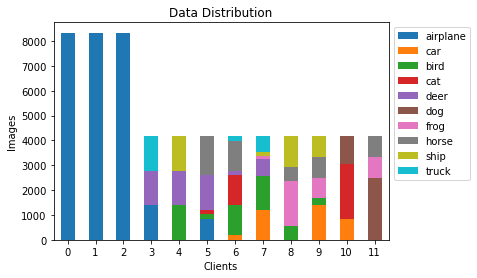

In [13]:
d={}
classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for label in classes:
    d[label] = [0 for i in range(len(local_datasets))]
    
df = pd.DataFrame(data=d)

for i, dataset in enumerate(local_datasets):
    labels = torch.zeros(len(classes), dtype=torch.long)
    for _, target in dataset:
        labels += F.one_hot(torch.tensor(target), num_classes=len(classes))
    df.iloc[i] = labels.tolist()

ax = df.plot.bar(stacked=True)
ax.set_title("Data Distribution")
ax.set_xlabel("Clients")
ax.set_ylabel("Images")
ax.tick_params(axis='x', labelrotation=0)
ax.legend(bbox_to_anchor=(1, 1))

In [14]:
# model = Net()
# server = Server()
# server.setup(args, model, dataset_server_test)

model = Net()
server = Server()

test_loader = torch.utils.data.DataLoader(dataset_server_test, batch_size=args["batch_size"], shuffle=True)
server.setup(args, model, test_loader)


	Federated Learning:

Round 1/10: Starting...
Send global model to all clients...

	Updating clients 0...
Train Epoch 0: 	Loss: 0.041
Validate Epoch 0: 	Loss: 0.000, 	Acc: 1.000
Train Epoch 1: 	Loss: 0.000
Validate Epoch 1: 	Loss: 0.000, 	Acc: 1.000
Train Epoch 2: 	Loss: 0.000
Validate Epoch 2: 	Loss: 0.000, 	Acc: 1.000


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Test: 	Loss: 0.000, 	Acc: 1.000
*************************

	Updating clients 1...
Train Epoch 0: 	Loss: 0.038
Validate Epoch 0: 	Loss: 0.000, 	Acc: 1.000
Train Epoch 1: 	Loss: 0.000
Validate Epoch 1: 	Loss: 0.000, 	Acc: 1.000
Train Epoch 2: 	Loss: 0.000
Validate Epoch 2: 	Loss: 0.000, 	Acc: 1.000
Test: 	Loss: 0.000, 	Acc: 1.000
*************************

	Updating clients 2...
Train Epoch 0: 	Loss: 0.039
Validate Epoch 0: 	Loss: 0.000, 	Acc: 1.000
Train Epoch 1: 	Loss: 0.000
Validate Epoch 1: 	Loss: 0.000, 	Acc: 1.000
Train Epoch 2: 	Loss: 0.000
Validate Epoch 2: 	Loss: 0.000, 	Acc: 1.000
Test: 	Loss: 0.000, 	Acc: 1.000
*************************

	Updating clients 3...
Train Epoch 0: 	Loss: 1.191
Validate Epoch 0: 	Loss: 1.255, 	Acc: 0.468
Train Epoch 1: 	Loss: 0.899
Validate Epoch 1: 	Loss: 0.910, 	Acc: 0.635
Train Epoch 2: 	Loss: 0.852
Validate Epoch 2: 	Loss: 0.964, 	Acc: 0.549
Test: 	Loss: 0.955, 	Acc: 0.558
*************************

	Updating clients 4...
Train Epoch 0: 	Loss: 1.

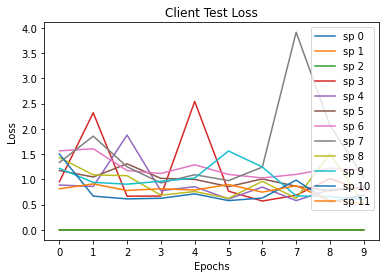

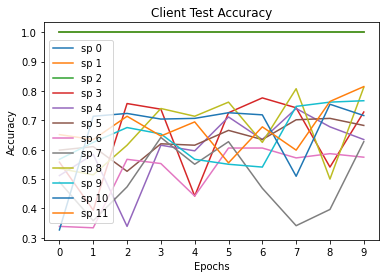


	Server:



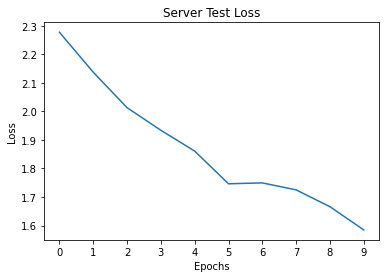

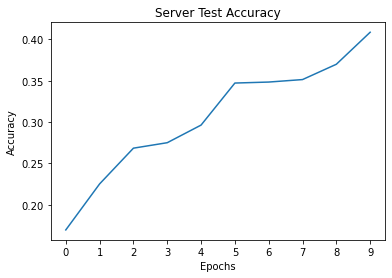

Federated Learning Execution Time: 1:06:26.621781


In [15]:
start_time = time.monotonic()
server.federated_learning()
end_time = time.monotonic()
print(f"Federated Learning Execution Time: {timedelta(seconds = end_time - start_time)}")

In [16]:
start_time = time.monotonic()
server.fed_unlearn(0, args["epochs"])
end_time = time.monotonic()
print(f"Federated Unlearning Execution Time: {timedelta(seconds = end_time - start_time)}")

Start unlearning...
unlearn malicious clients...
*************************
unlearn round 1:
*************************
unlearn round 2:
-------------------------
Client 3 cali train...
Train Epoch 0: 	Loss: 0.512
Validate Epoch 0: 	Loss: 1.092, 	Acc: 0.593
Train Epoch 1: 	Loss: 0.448
Validate Epoch 1: 	Loss: 0.493, 	Acc: 0.812
Test: 	Loss: 0.488, 	Acc: 0.827
-------------------------
Client 4 cali train...
Train Epoch 0: 	Loss: 0.655
Validate Epoch 0: 	Loss: 0.582, 	Acc: 0.729
Train Epoch 1: 	Loss: 0.575
Validate Epoch 1: 	Loss: 0.781, 	Acc: 0.656
Test: 	Loss: 0.711, 	Acc: 0.704
-------------------------
Client 5 cali train...
Train Epoch 0: 	Loss: 0.847
Validate Epoch 0: 	Loss: 0.902, 	Acc: 0.662
Train Epoch 1: 	Loss: 0.761
Validate Epoch 1: 	Loss: 0.769, 	Acc: 0.740
Test: 	Loss: 0.809, 	Acc: 0.707
-------------------------
Client 6 cali train...
Train Epoch 0: 	Loss: 0.958
Validate Epoch 0: 	Loss: 1.173, 	Acc: 0.550
Train Epoch 1: 	Loss: 0.879
Validate Epoch 1: 	Loss: 1.613, 	Acc: 0.4

In [17]:
server.unlearned_model
model = Net()
server = Server()

test_loader = torch.utils.data.DataLoader(dataset_server_test, batch_size=args["batch_size"], shuffle=True)
server.setup(args, model, test_loader)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [18]:
def compare_unlearn_client(initial_weight=server.get_weight(), unlearned_weight=server.unlearned_model.state_dict(), is_unlearned=True):
    label = []
    before_acc_list = []
    after_acc_list = []
    
    if is_unlearned:
        for client in args["clients"]:
            if client.id in args["unlearn_client_list"]:            
                client.model.load_state_dict(initial_weight)
                client.criterion = torch.nn.CrossEntropyLoss()
                before_loss, before_acc = client.test(client.model)
                
                client.model.load_state_dict(unlearned_weight)
                after_loss, after_acc = client.test(client.model)
                
                label.append(f"client {client.id}")
                before_acc_list.append(round(before_acc, 3))
                after_acc_list.append(round(after_acc, 3))
                
                print(f"Client {client.id}:\tAcc: {before_acc:.3f} -> {after_acc:.3f}")
                
    else:
        for client in args["clients"]:
            if client.id not in args["unlearn_client_list"]:
                client.model.load_state_dict(initial_weight)
                client.criterion = torch.nn.CrossEntropyLoss()
                before_loss, before_acc = client.test(client.model)
                
                client.model.load_state_dict(unlearned_weight)
                after_loss, after_acc = client.test(client.model)
                
                print(f"Client {client.id}:\tAcc: {before_acc:.3f} -> {after_acc:.3f}")
                
    return label, before_acc_list, after_acc_list
            


def compare_unlearn_server(initial_weight=server.get_weight(), unlearned_weight=server.unlearned_model.state_dict()):
    before_model = Net()
    after_model = Net()
    before_model.load_state_dict(initial_weight)
    after_model.load_state_dict(unlearned_weight)
    before_loss, before_acc = server.test_global_model(before_model)
    after_loss, after_acc = server.test_global_model(after_model)
    
    print(f"Server:\tAcc: {before_acc:.3f} -> {after_acc:.3f}")
    
    return before_acc, after_acc


	Client
Client 3:	Acc: 0.421 -> 0.428
Client 4:	Acc: 0.447 -> 0.719
Client 5:	Acc: 0.555 -> 0.589
Client 6:	Acc: 0.430 -> 0.630
Client 7:	Acc: 0.526 -> 0.690
Client 8:	Acc: 0.452 -> 0.642
Client 9:	Acc: 0.517 -> 0.733
Client 10:	Acc: 0.233 -> 0.411
Client 11:	Acc: 0.228 -> 0.337

	Unlearned Client
Client 0:	Acc: 0.347 -> 0.039
Client 1:	Acc: 0.373 -> 0.028
Client 2:	Acc: 0.291 -> 0.003


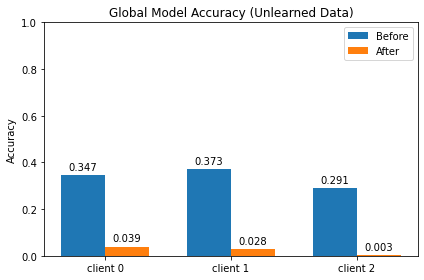


\Server

Server: Loss: 1.5863, Accuracy: 4086/10000 (40.86%)


Server: Loss: 1.3128, Accuracy: 5271/10000 (52.71%)

Server:	Acc: 0.409 -> 0.527


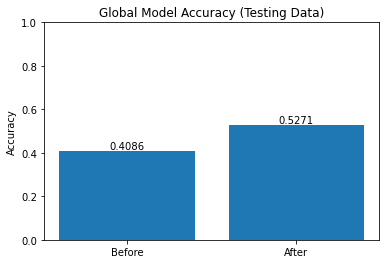

In [19]:
print("\n\tClient")
compare_unlearn_client(is_unlearned=False)
  
print("\n\tUnlearned Client")
unlearned_clients, before_acc, after_acc = compare_unlearn_client()

x = np.arange(len(unlearned_clients))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_acc, width, label='Before')
rects2 = ax.bar(x + width/2, after_acc, width, label='After')

ax.set_ylabel('Accuracy')
ax.set_title('Global Model Accuracy (Unlearned Data)')
ax.set_xticks(x)
ax.set_xticklabels(unlearned_clients)
ax.set_ylim([0, 1])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

    
print("\n\Server")
before_acc, after_acc = compare_unlearn_server()
labels = ["Before", "After"]
values=[before_acc, after_acc]
fig = plt.figure()
plt.bar(labels, values)
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Global Model Accuracy (Testing Data)")
for index, value in enumerate(values):
    plt.text(index, value,str(round(value, 4)), ha="center", va="bottom")
plt.show()


	Client
Client 3:	Acc: 0.421 -> 0.428
Client 4:	Acc: 0.447 -> 0.719
Client 5:	Acc: 0.555 -> 0.589
Client 6:	Acc: 0.430 -> 0.630
Client 7:	Acc: 0.526 -> 0.690
Client 8:	Acc: 0.452 -> 0.642
Client 9:	Acc: 0.517 -> 0.733
Client 10:	Acc: 0.233 -> 0.411
Client 11:	Acc: 0.228 -> 0.337

	Unlearned Client
Client 0:	Acc: 0.383 -> 0.000
Client 1:	Acc: 0.373 -> 0.000
Client 2:	Acc: 0.291 -> 0.000


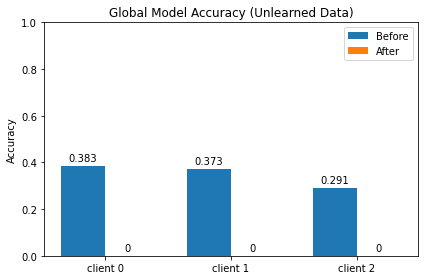


\Server

Server: Loss: 1.5867, Accuracy: 4086/10000 (40.86%)


Server: Loss: 8.0249, Accuracy: 1463/10000 (14.63%)

Server:	Acc: 0.409 -> 0.146


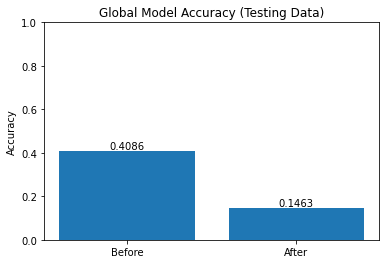

In [20]:
print("\n\tClient")
compare_unlearn_client(is_unlearned=False)

print("\n\tUnlearned Client")
unlearned_clients, before_acc, after_acc = compare_unlearn_client(initial_weight=server.get_weight(), unlearned_weight=server.global_unlearned_model_record[0], is_unlearned=True)

x = np.arange(len(unlearned_clients))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_acc, width, label='Before')
rects2 = ax.bar(x + width/2, after_acc, width, label='After')

ax.set_ylabel('Accuracy')
ax.set_title('Global Model Accuracy (Unlearned Data)')
ax.set_xticks(x)
ax.set_xticklabels(unlearned_clients)
ax.set_ylim([0, 1])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


print("\n\Server")
before_acc, after_acc = compare_unlearn_server(initial_weight=server.get_weight(), unlearned_weight=server.global_unlearned_model_record[0])
labels = ["Before", "After"]
values=[before_acc, after_acc]
fig = plt.figure()
plt.bar(labels, values)
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Global Model Accuracy (Testing Data)")
for index, value in enumerate(values):
    plt.text(index, value,str(round(value, 4)), ha="center", va="bottom")
plt.show()

In [21]:
for client in args["clients"]:
    client.cali_ratio = 0.8

start_time = time.monotonic()
server.fed_unlearn(0, args["epochs"])
end_time = time.monotonic()
print(f"Federated Unlearning Execution Time: {timedelta(seconds = end_time - start_time)}")

Start unlearning...
unlearn malicious clients...
*************************
unlearn round 1:
*************************
unlearn round 2:
-------------------------
Client 3 cali train...
Train Epoch 0: 	Loss: 0.376
Validate Epoch 0: 	Loss: 0.395, 	Acc: 0.863
Train Epoch 1: 	Loss: 0.293
Validate Epoch 1: 	Loss: 0.466, 	Acc: 0.829
Train Epoch 2: 	Loss: 0.278
Validate Epoch 2: 	Loss: 0.694, 	Acc: 0.801
Test: 	Loss: 0.481, 	Acc: 0.829
-------------------------
Client 4 cali train...
Train Epoch 0: 	Loss: 0.480
Validate Epoch 0: 	Loss: 0.819, 	Acc: 0.656
Train Epoch 1: 	Loss: 0.392
Validate Epoch 1: 	Loss: 0.472, 	Acc: 0.802
Train Epoch 2: 	Loss: 0.387
Validate Epoch 2: 	Loss: 0.596, 	Acc: 0.760
Test: 	Loss: 0.595, 	Acc: 0.774
-------------------------
Client 5 cali train...
Train Epoch 0: 	Loss: 0.661
Validate Epoch 0: 	Loss: 0.718, 	Acc: 0.753
Train Epoch 1: 	Loss: 0.580
Validate Epoch 1: 	Loss: 1.049, 	Acc: 0.625
Train Epoch 2: 	Loss: 0.534
Validate Epoch 2: 	Loss: 0.963, 	Acc: 0.630
Test: 


	Client
Client 3:	Acc: 0.421 -> 0.303
Client 4:	Acc: 0.447 -> 0.000
Client 5:	Acc: 0.555 -> 0.207
Client 6:	Acc: 0.430 -> 0.000
Client 7:	Acc: 0.526 -> 0.000
Client 8:	Acc: 0.452 -> 0.000
Client 9:	Acc: 0.517 -> 0.000
Client 10:	Acc: 0.233 -> 0.000
Client 11:	Acc: 0.228 -> 0.000

	Unlearned Client
Client 0:	Acc: 0.347 -> 1.000
Client 1:	Acc: 0.373 -> 1.000
Client 2:	Acc: 0.291 -> 1.000


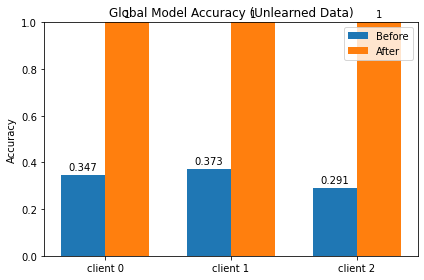


\Server

Server: Loss: 1.5865, Accuracy: 4086/10000 (40.86%)


Server: Loss: nan, Accuracy: 1000/10000 (10.00%)

Server:	Acc: 0.409 -> 0.100


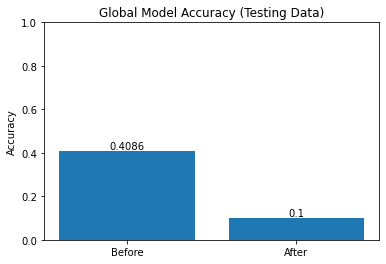

In [23]:
print("\n\tClient")
compare_unlearn_client(is_unlearned=False)
  
print("\n\tUnlearned Client")
unlearned_clients, before_acc, after_acc = compare_unlearn_client()

x = np.arange(len(unlearned_clients))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_acc, width, label='Before')
rects2 = ax.bar(x + width/2, after_acc, width, label='After')

ax.set_ylabel('Accuracy')
ax.set_title('Global Model Accuracy (Unlearned Data)')
ax.set_xticks(x)
ax.set_xticklabels(unlearned_clients)
ax.set_ylim([0, 1])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

    
print("\n\Server")
before_acc, after_acc = compare_unlearn_server()
labels = ["Before", "After"]
values=[before_acc, after_acc]
fig = plt.figure()
plt.bar(labels, values)
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Global Model Accuracy (Testing Data)")
for index, value in enumerate(values):
    plt.text(index, value,str(round(value, 4)), ha="center", va="bottom")
plt.show()